In [7]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
import numpy.random as npr
import warnings
warnings.filterwarnings("ignore")

In [8]:
X = np.load('ship_data.npy')
y = np.load('ship_labels.npy')

In [13]:
X.shape

(4000, 80, 80, 3)

In [14]:
y.shape

(4000,)

In [15]:
X.shape, y.shape

((4000, 80, 80, 3), (4000,))

In [16]:
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

In [57]:
import numpy as np
import time
import joblib
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

def measure_inference_time(model, X_test, iterations=10):
    """
    Measure average inference time over multiple iterations
    """
    inference_times = []
    for _ in range(iterations):
        start_time = time.time()
        model.predict(X_test)
        inference_times.append(time.time() - start_time)
    return np.mean(inference_times)

def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluate model performance and inference time
    """
    # Measure inference time
    avg_inference_time = measure_inference_time(model, X_test)
    
    # Get predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'F1-Score': f1,
        'Inference Time (s)': avg_inference_time
    }

def main():
    # Load test data
    X_test = np.load('ship_data.npy')  # Make sure to use your actual test data
    y_test = np.load('ship_labels.npy')  # Make sure to use your actual test labels
    
    # Reshape test data
    n_samples, height, width, channels = X_test.shape
    X_test_flat = X_test.reshape(n_samples, height * width * channels)
    
    # List of models to evaluate
    models = {
        'Q1_LR': 'Q1LinearRegression.pkl',
        'Q1_RF': 'Q1RandomForest.pkl',
        'Q3_LR_PCA': 'Q3linearRegression.pkl',
        'Q3_RF_PCA': 'Q3randomForest.pkl',
        'Q

    }
    
    # Store results
    results = []
    
    # Evaluate each model
    for model_name, model_path in models.items():
        try:
            # Load model
            model = joblib.load(model_path)
            
            # Evaluate model
            result = evaluate_model(model, X_test_flat, y_test, model_name)
            results.append(result)
            
        except Exception as e:
            print(f"Error evaluating {model_name}: {str(e)}")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Print results
    print("\nModel Performance and Inference Time Comparison:")
    print("="*80)
    print(results_df.to_string(index=False))
    print("\nDetailed Analysis:")
    print("="*80)
    
    # Calculate and print additional statistics
    for metric in ['Accuracy', 'F1-Score', 'Inference Time (s)']:
        print(f"\n{metric} Statistics:")
        print(f"Best Model: {results_df.loc[results_df[metric].idxmax(), 'Model']} "
              f"(Value: {results_df[metric].max():.4f})")
        print(f"Average across all models: {results_df[metric].mean():.4f}")
        print(f"Standard deviation: {results_df[metric].std():.4f}")

if __name__ == "__main__":
    main()


Model Performance and Inference Time Comparison:
    Model  Accuracy  F1-Score  Inference Time (s)
    Q1_LR    0.9775  0.955839            0.082815
    Q1_RF    0.9900  0.979716            0.126647
Q3_LR_PCA    0.8705  0.717557            0.424058
Q3_RF_PCA    0.9910  0.981707            0.469746

Detailed Analysis:

Accuracy Statistics:
Best Model: Q3_RF_PCA (Value: 0.9910)
Average across all models: 0.9573
Standard deviation: 0.0582

F1-Score Statistics:
Best Model: Q3_RF_PCA (Value: 0.9817)
Average across all models: 0.9087
Standard deviation: 0.1280

Inference Time (s) Statistics:
Best Model: Q3_RF_PCA (Value: 0.4697)
Average across all models: 0.2758
Standard deviation: 0.1992


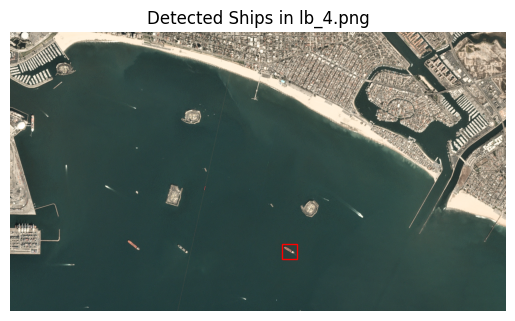

In [75]:
import os
import cv2
import matplotlib.pyplot as plt

def detect_ships_in_scene(image_path, model_pipeline, patch_size=(80, 80)):
    large_image = cv2.imread(image_path)
    if large_image is None:
        print(f"Unable to load {image_path}. Exiting...")
        return

    # Collecting dimensions of the actual image
    h, w, _ = large_image.shape

    # Storing ship coordinates
    ship_locations = []

    # Patch traversing 
    for y in range(0, h - patch_size[1] + 1, patch_size[1]):
        for x in range(0, w - patch_size[0] + 1, patch_size[0]):
            # Patch by patch processing
            patch = large_image[y:y + patch_size[1], x:x + patch_size[0]]

            # Patch flattening
            patch_flat = patch.flatten().reshape(1, -1)

            # Prediction
            prediction = model_pipeline.predict(patch_flat)
            if prediction == 1:
                ship_locations.append((x, y))

    # Displaying image
    plt.figure()
    plt.imshow(cv2.cvtColor(large_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Detected Ships in {os.path.basename(image_path)}")

    # Drawing rectangles (in this case square (80x80 / bounding box)) around the detected ship
    for (x, y) in ship_locations:
        rect = plt.Rectangle((x, y), patch_size[0], patch_size[1],
                             linewidth=1, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)

    plt.axis('off')
    plt.show()

image_path = 'lb_4.png'  
#trained model pipeline RandomForest 
model_pipeline = joblib.load("Q3randomForest.pkl")
detect_ships_in_scene(image_path, model_pipeline)